# Maze Solver Using Reinforcement Learning

Maze solver by using Q-Values

We First start by defining required environment details then move to training the agent with reinforcement learning then lastly by using genetic algorithms, we find best hyperparameters for the current maze so that we can train the agent with best quality.

## Imports

In [1]:
import matplotlib.pyplot as plt                # For Plotting
import numpy as np                             # For Environment Operations
import random                                  # For Genetic Algorithm  
import imageio                                 # For video recording actions
import gym                                     # The General Framework of the environment
import math                                    # Distance Calculations 
import copy                                    # Deep and shallow copies
import os                                      # Write maze runner records to disk
import pandas as pd                            # Data Analysis
import sys                                     # Flush stdout
from IPython.display import Image as Img       # Show Gifs of the Records in Notebook
from pathlib import Path                       # Image, Record paths
from mazelab import BaseMaze                   # The Framework of the environment
from mazelab import Object                  
from mazelab import DeepMindColor as color
from mazelab import BaseEnv                    # Base Environment Class
from mazelab import VonNeumannMotion           # North, South, West, East Motions
from gym.envs.classic_control import rendering # For rendering images
from gym.spaces import Box                     
from gym.spaces import Discrete
from PIL import Image                          # Rendering images

## Environment

In [2]:
class Env(BaseEnv):
    """
    The environment of the Maze Solver
    
    Defines basics like stepping, rendering maze to image and also supports video recording with the help of BaseEnv
    """
    
    def __init__(self):
        super().__init__()
        # Set Maze
        self.maze = maze_env.get_maze()
        # Define Observation Space
        self.observation_space = Box(low=0, high=len(self.maze.objects), shape=self.maze.size, dtype=np.uint8)
        # Set Actions
        self.motions = VonNeumannMotion()
        # Define Action Space
        self.action_space = Discrete(len(self.motions))
        
    def step(self, action):
        """
        Take action on the environment
        """
        # Take the motion that the action points
        motion = self.motions[action]                      # North, South, West, East Motions
        # Take the agent's current position
        current_position = self.maze.objects.agent.positions[0]
        # Calculate new position after we take the action
        new_position = [current_position[0] + motion[0], current_position[1] + motion[1]]
        # check whether the the new position is a wall or something alike
        valid = self._is_valid(new_position)
        
        # If the result of the action to be taken is a valid position, then update the agent's position
        if valid:
            self.maze.objects.agent.positions = [new_position]
        
        # Since we use Reinforcement Learning, we give rewards to actions
        reward = 0
        # If the goal position is reached
        if self._is_goal(new_position): 
            reward = 10_000                
            done = True
        # If the position is wall
        elif not valid:
            reward = -100
            done = False
        # Since every step takes time, 
        # we give punishment for every step taken to make the agent minimize n_steps
        else:
            reward = -10
            done = False
        # Return state,reward, done, info
        return self.s, reward, done, {}
    
    
    def encode(self, agent_x, agent_y):
        """
        Change the state of the environment 
        into another by moving the agent to given position
        """
        self.maze.objects.agent.positions[0] = [agent_x, agent_y]
        return self.s
    
    def get_maze(self):
        """
        Get maze in matrix form.
        Here 2 shows the agent's position, 
        3 shows the goal position and 1s shows the walls
        """
        return self.maze.to_value()
    
    def reset(self):
        """
        Reset the Maze to the initial state
        """
        self.maze.objects.agent.positions = maze_env.start_idx
        self.maze.objects.goal.positions = maze_env.goal_idx
        return self.s
    
    def _is_valid(self, position):
        """
        Is given position valid? or the position have some obstacle?
        """
        nonnegative = position[0] >= 0 and position[1] >= 0
        within_edge = position[0] < self.maze.size[0] and position[1] < self.maze.size[1]
        passable = not self.maze.to_impassable()[position[0]][position[1]]
        return nonnegative and within_edge and passable
    
    def _is_goal(self, position):
        """
        Have we reached to the goal position?
        """
        out = False
        goal_position = self.maze.objects.goal.positions[0]
        if goal_position[0] == position[0] and goal_position[1] == position[1]:
            return True
        return False
    
    def get_image(self):
        """
        Convert the maze to RGB Array so that we can print it out
        """
        return self.maze.to_rgb()
    
    def render(self, mode='human', max_width=500):
        """
        Print the maze as image of max_width length.
        
        Here careful to max_width, it can make the image blurry if not equal to the actual size of the image 
        """
        # Get the image of the maze
        img = self.get_image()
        # Conver the image into RGB array
        img = np.asarray(img).astype(np.uint8)
        # Scale up the image by 10 without loosing any quality
        # Here be careful, for big mazes, 10 may be high
        img = Env.repeat_upsample(img,10, 10)
        # Return the image
        img = np.asarray(img)
        if mode == 'rgb_array':
            return img
        elif mode == 'human':
            from gym.envs.classic_control.rendering import SimpleImageViewer
            if self.viewer is None:
                self.viewer = SimpleImageViewer()
            self.viewer.imshow(img)
            
            return self.viewer.isopen
        
    @property
    def s(self):
        """
        Get the state of the maze
        Every state is a mapping from agent's position(x,y) to Szudzik Pairing Value 
        """
        x,y = self.maze.objects.agent.positions[0]
        return Env.pair(x,y)
    
    def get_agent_position(self):
        """
        Simple unpair the state(Szudzik Pairing Value) to get the agent's positions
        """
        return Env.unpair(self.s)
        
    @staticmethod
    def pair(x,y):
        """
        By using Szudzik Pairing, get the one dimentional value for x,y pair
        """
        return y*y+x if y > x else x*x+x+y

    @staticmethod
    def unpair(z):
        """
        Get the x,y coordinates back from the Szudzik Pairing Value
        """
        q = math.floor(math.sqrt(z))
        l = z - q ** 2
        return (l, q) if l < q else (q,(l-q)) 
    
    @staticmethod
    def repeat_upsample(rgb_array, k=1, l=1, err=[]):
        """
        Upscale the maze image by KxL
        
        Taken from https://github.com/openai/gym/issues/550
        """
        # repeat kinda crashes if k/l are zero
        if k <= 0 or l <= 0: 
            if not err: 
                print(f"Number of repeats must be larger than 0, k: {k}, l: {l}, returning default array!")
                err.append('logged')
            return rgb_array

        # repeat the pixels k times along the y axis and l times along the x axis
        # if the input image is of shape (m,n,3), the output image will be of shape (k*m, l*n, 3)

        return np.repeat(np.repeat(rgb_array, k, axis=0), l, axis=1)

In [3]:
class MazeEnvironment:
    """
    Initiate appropriate Maze with the provided sizes and obstacle lengths
    """
    def __init__(self, size, k, obstacle_len=4):
        self.size = size
        self.k = k
        self.obstacle_len = obstacle_len
        self.env = self.generate_env()
        
        self.start_idx = [[1, 1]]
        self.goal_idx = [[self.size[0]-2, self.size[1]-2]]
        self.env_id = 'SimpleEmptyMaze-v0'
        # Register the environment, here the max episode steps should be high 
        # so that we make sure the agent met the goal position
        try:
            gym.envs.register(id=self.env_id, entry_point=Env, max_episode_steps=1_000_000)
        except:
            del gym.envs.registration.registry.env_specs[self.env_id]
            gym.envs.register(id=self.env_id, entry_point=Env, max_episode_steps=1_000_000)
    
    def get_maze(self):
        """
        Get the maze where every position is defined strictly.
        0 -> Free
        1 -> Obstacle
        2 -> Agent
        3 -> Goal
        """
        x = self.env
        class Maze(BaseMaze):
            @property
            def size(self):
                return x.shape

            def make_objects(self):
                free = Object('free', 0, color.free, False, np.stack(np.where(x == 0), axis=1))
                obstacle = Object('obstacle', 1, color.obstacle, True, np.stack(np.where(x == 1), axis=1))
                agent = Object('agent', 2, color.agent, False, [])
                goal = Object('goal', 3, color.goal, False, [])
                return free, obstacle, agent, goal
        return Maze()
    
    def set_start(start_idx):
        """
        Update start index
        """
        self.start_idx = start_idx
    
    def set_goal(goal_idx):
        """
        Update goal index
        """
        self.goal_idx = goal_idx
    
    def generate_env(self):
        """
        k -> number of obstacles
        """
        # Start environment with array of Zeros where 0's are free spaces, 1's are the walls
        arr = np.zeros(shape=self.size, dtype=int)
        # Create Left-Right Walls
        for i in range(self.size[0]):
            arr[i, 0] = 1
            arr[i, self.size[1] - 1] = 1

        # Create Bottom-Up Walls
        for i in range(self.size[1]):
            arr[0, i] = 1
            arr[self.size[0] - 1, i] = 1

        # Now environment walls are generated now lets add obstacles

        # Generate k Obstacles
        for i in range(self.k):
            # Choose random point to put the current obstacle
            row = random.randrange(1, self.size[0] - 1 - self.obstacle_len)
            column = random.randrange(1, self.size[1] - 1 - self.obstacle_len)

            # Roll dice to decide whether to put the obstacle in vertical or in horizontal shape
            isVertical = random.randint(0, 1)
            if isVertical == 1:
                for j in range(self.obstacle_len):
                    arr[row, column + j] = 1
            else:
                for j in range(self.obstacle_len):
                    arr[row + j, column] = 1

        return arr

In [4]:
# This one has to be defined globally because of how the Env is defined.
maze_env = MazeEnvironment((20, 20), 20)

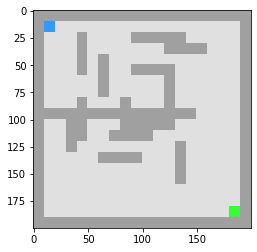

In [5]:
env = gym.make(maze_env.env_id)
env.reset()
img = env.render('rgb_array')
plt.imshow(img)

## Q Table

We will be using Szudzik Pairing Function in order to convert two dimentional points x,y into one dimentional state numbers.

Here we use the agent's position in order to encode the state numbers of the environment since the goal and walls are static.

Normally for 20x20 maze we have 400 possible positions the agent can be. But since we use conversion function we have some extra states which we will not be using.

In [6]:
# As we can see, 40 extra states has been assigned.
Env.pair(20,20) # for 20x20 Maze

440

In [7]:
# Here also 200 extra states assigned 
# but we ignore since it is just 2% of the whole states
Env.pair(100,100) # for 100x100 Maze

10200

In [8]:
# Lets get the number of states for the current environment wihch is 20x20
n_states = Env.pair(env.maze.size[0], env.maze.size[1]) # Get Maximum State Number
n_states # The position of agent expresses the state of the board

440

In [9]:
# Now we get the size of the possible actions
n_actions = env.action_space.n 
n_actions # North, South, West, East in this order

4

In [10]:
# Now it's time to create q_table which is a mapping of every state to every action
q_table = np.zeros([n_states, n_actions])        # Table of n_states x n_actions
q_table.shape

(440, 4)

In [11]:
# Every entry is shows the probability of the action.
# Where 0th->North 1st->South 2nd->West 3rd->East
q_table[3]

array([0., 0., 0., 0.])

Having created the q table, we need to get the appropriate probabilities for possible actions by training the agent. 

## Training The Agent

Here we train the agent. 

Once the environment has been learnt, the agent can make intelligent decisions based on the past observations.

In [12]:
# Hyperparameters
  
alpha = 0.38342121                     # Learning Rate
gamma = 0.65597983                     # Importance of long term rewards
epsilon = 0.16808267                   # The chance of random move rather than learned one.

In [13]:
for i in range(1, 1_000):
    state = env.reset()                                     # Start
    epochs, penalties, reward = 0, 0, 0                     # init variables
    done = False
    max_iter = 20_000
    while not done:                                         # while the agent has not finished
        # Decide whether or not go random or use qtable
        if random.uniform(0,1) < epsilon: 
            action = env.action_space.sample()              # Explore the action space
        else:
            action = np.argmax(q_table[state])              # Use learnt q-values
        
        # Act and get respond from the environment
        next_state, reward, done, _ = env.step(action)
        
        # Update Q-Value of the current state
        old_q_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        new_q_value = (1 - alpha) * old_q_value + (alpha * (reward + (gamma * next_max)) )
        q_table[state, action] = round(new_q_value,5)
        
        if reward == -100:
            penalties += 1
        
        state = next_state
        epochs += 1
        max_iter -= 1
        if max_iter == 0:
            break

## Run and Visualize The Agent Actions

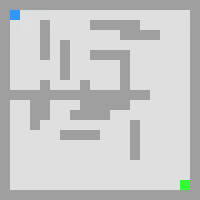

In [14]:
img = env.render('rgb_array')
env = gym.wrappers.Monitor(env, './', force=True, uid=42)
env.reset()
done = False
while not done:
    action = np.argmax(q_table[state])
    state, reward, done, info = env.step(action)
env.close()
f = list(Path('./').glob('*.mp4'))[0]
reader = imageio.get_reader(f)
f = f'./{maze_env.env_id}.gif'
with imageio.get_writer(f, fps=50) as writer:
    [writer.append_data(img) for img in reader]
Img(f)

In [15]:
env.close()

## Optimizing The Hyperparameters By Using Genetic Algorithms

In [27]:
class GeneticOptimizer:
    """
    Optimizes the hyperparameters of the reinforcement learning.
    
    Here we use Genetic Algorithm in order to generate appropriate hyperparameters.
    See this article to understand whats going on here.
    https://towardsdatascience.com/introduction-to-optimization-with-genetic-algorithm-2f5001d9964b
    """
    
    def __init__(self, maze_env, max_episodes):
        # Init the environment
        self.env = gym.make(maze_env.env_id)
        
        # Here we define the max epochs when we train the agent.
        self.max_episodes = max_episodes
        
        # When creating q_table in training phase, we need the number of states
        self.n_states = Env.pair(self.env.maze.size[0], self.env.maze.size[1])
        
    def run(self, n_generations=100, solution_per_population=10, n_parents=3, mutation_probability=0.5):
        """
        Optimize the hyperparameters and return the best hyperparameters found in every generation.
        """
        
        # Creating the initial population
        n_genes=3  # alpha, gamma, epsilon in sequence
        population_size = (solution_per_population, n_genes)
        new_population = np.random.uniform(low=0, high=1, size=population_size)
        
        # Store best chromosome of each generation
        best_chromosomes = []

        for generation in range(n_generations):
            
            # Print the best results of current iteration, for debugging purposes
            pop_fitness = self.population_fitness(new_population)
            max_fitness = np.max(pop_fitness)
            print(f"Generation: {generation}\tBest Fitness : {max_fitness:.2f}")
            curr_best_match_idx = np.where(pop_fitness == np.max(pop_fitness))
            print(new_population[curr_best_match_idx])
            
            # Save the best chromosome of this run as deepcopy
            best_chromosomes.append(copy.deepcopy(new_population[curr_best_match_idx])[0])

            # Calculate fitness of each chromosome by running each choromosome of actions in the maze
            fitness_values = self.population_fitness(new_population)

            # Select the best parents for mating
            best_parents = GeneticOptimizer.select_best_parents(new_population, fitness_values, n_parents)

            # Generate next generation using cross-over
            offspring_crossover = GeneticOptimizer.cross_over(best_parents, offspring_size=(population_size[0], population_size[1]))

            # Add some variations to offsprings using mutation.
            mutated_offsprings = GeneticOptimizer.mutate(offspring_crossover, mutation_probability)

            # Create the new generation based on offsprings
            new_population[:,:] = mutated_offsprings

        return best_chromosomes
            
    def train_agent(self, chromosome):
        """
        Train The Agent
        """
        # Get the current solution's hyperparameters
        alpha, gamma, epsilon = chromosome
        alpha = round(alpha, 5)
        gamma = round(gamma, 5)
        epsilon = round(epsilon, 5)
        # Create q_table in every training, 
        # remember we aim to find best q table in min. amount of time
        q_table = np.zeros([self.n_states, 4])     # Table of n_states x n_actions
        
        # Keep track of the quality of the training 
        # for further detecting the fitness of solutions later in other functions.
        total_epochs = 0
        total_penalties= 0
        total_rewards = 0
        print(f"Training, {alpha},{gamma},{epsilon}")
        # Train self.max_episodes times
        for i in range(1, self.max_episodes):
            state = self.env.reset()                                # Start
            epochs, penalties, rewards, reward = 0, 0, 0, 0         # init variables
            done = False
            i = 2_000
            while not done:                                         # while the agent has not finished
                # Decide whether or not go random or use qtable
                if random.uniform(0,1) < epsilon: 
                    action = self.env.action_space.sample()         # Explore the action space
                else:
                    action = np.argmax(q_table[state])              # Use learnt q-values

                # Act and get respond from the environment
                next_state, reward, done, _ = self.env.step(action) 
                
                # Update Q-Value of the current state
                old_q_value = q_table[state, action]
                next_max = np.max(q_table[next_state])
                #print(f"old={old_q_value}, next_max={next_max}")
                new_q_value = (1 - alpha) * old_q_value + alpha * (reward + gamma * next_max)
                q_table[state, action] = round(new_q_value,5)
                
                # See this article to understand how we update the q_values 
                # https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/
                
                # Count the number of times we hit a wall
                if reward == -100:
                    penalties += 1
                
                state = next_state
                epochs += 1
                rewards += reward
                i -= 1
                if i == 0:
                    break
                
            total_epochs += epochs
            total_penalties += penalties
            total_rewards += reward
        return total_epochs, total_penalties, total_rewards
    
    def population_fitness(self, population):
        """
        Calculate the fitness of each choromosome found in the population. 
        """
        fitness_values = np.empty(population.shape[0])
        i = 0
        
        # Here the population consists of list of chromosomes 
        # where each chromose is actually list of hyperparameters
        for chromosome in population:
            # Take the chromosome and run in the maze
            (n_steps, n_penalties, total_rewards) = self.train_agent(chromosome)
            # Calculate the fitness of chromosome
            chromosome_fitness = GeneticOptimizer.fitness(population=population, 
                                                          n_steps=n_steps, 
                                                          n_penalties=n_penalties, 
                                                          total_rewards=total_rewards)
            # Save the fitness value
            fitness_values[i] = chromosome_fitness
            i += 1

        return fitness_values

    @staticmethod
    def fitness(population, n_steps, n_penalties, total_rewards):
        """
        Calculate fitness of a chromosome
        Higher the fitness value, better the current chromosome is.
        """
        accuracy_points = (1/n_penalties)*1_000 if n_penalties != 0 else 1000
        speed_points = (1 / n_steps) * 1_000
        intelligence_points = total_rewards // 10
        avg_intelligence_points = (total_rewards / n_steps)*100

        total_points = accuracy_points + intelligence_points +speed_points + avg_intelligence_points

        return total_points
    
    @staticmethod
    def select_best_parents(population, fitness_values, n_parents):
        """
        Selecting the best individuals in the current generation as parents 
         for producing the offsprings of the next generation.
        """
        parents = np.empty((n_parents, population.shape[1]))
        for parent in range(n_parents):
            # Get the index of the fittest chromosome
            max_fitness_idx = np.where(fitness_values == np.max(fitness_values))
            max_fitness_idx = max_fitness_idx[0][0]
            # Save it as parent
            parents[parent, :] = population[max_fitness_idx, :]
            # Make sure we wont be selecting same chromosome again
            fitness_values[max_fitness_idx] = -999999
            
        # Return fittest chromosomes as parents
        return parents 
    
    @staticmethod
    def cross_over(parents, offspring_size):
        """
        Cross over the parents and get offsprings
        """
        offspring = np.empty(offspring_size)   # Childs generated
        
        # Generate offspring_size[0] piece offspring
        for k in range(offspring_size[0]):
            # For Each of them
            
            # Choose random parents
            parent_1_idx = random.randint(0,parents.shape[0]-1)
            parent_2_idx = random.randint(0,parents.shape[0]-1)

            # No need to do cross over when both parents are the same
            if parent_1_idx == parent_2_idx:
                continue

            # Take random portion of each gene of the chromosome from randomly selected parent
            
            # First Start by selecting dominant parents randomly for each choromosome
            #  here remember each chromosome is (alpha, gamma, epsilon) tuples
            #  where alpha is first gene of the chromosome.
            genes_source = np.random.randint(low=0, high=2, size=offspring_size[1])
            for gene_idx in range(offspring_size[1]):
                # For each gene
                if (genes_source[gene_idx] == 0):  # If the first parent is dominant parent
                    # The gene will be copied from the first parent if the current gene index is 0.
                    offspring[k, gene_idx] = 0.8 * parents[parent_1_idx, gene_idx] + 0.2 * parents[parent_2_idx, gene_idx]
                elif (genes_source[gene_idx] == 1): # If the second parent is dominant parent
                    # The gene will be copied from the second parent if the current gene index is 1.
                    offspring[k, gene_idx] = 0.8 * parents[parent_2_idx, gene_idx] + 0.2 * parents[parent_1_idx, gene_idx]
                # Here I've chosen 0.8 and 0.2 randomly, feel free to play with it.
                
        return offspring
    
    @staticmethod
    def mutate(offspring_crossover, mutation_probability):
        """
        Mutate genes in each offspring randomly.
        """
        if mutation_probability > np.random.rand():
            # For each offspring
            for idx in range(offspring_crossover.shape[0]):
                # Visit random number of genes and mutate them
                
                # Number of genes to mutate
                n_genes = random.randint(0, (offspring_crossover.shape[1])//4)
                for i in range(n_genes):
                    # Choose random gene to mutate
                    random_gene = random.randint(0, offspring_crossover.shape[1]-1)
                    # Mutate
                    if np.random.rand() >  mutation_probability / 2:
                        offspring_crossover[idx, random_gene] = random.uniform(0,1)
                    else:
                        offspring_crossover[idx, random_gene] -= offspring_crossover[idx, random_gene] * random.uniform(0,1)
        return offspring_crossover

In [32]:
x = GeneticOptimizer(maze_env, max_episodes=10)

In [33]:
best_chromosomes = x.run(n_generations=10, solution_per_population=10, n_parents=3)

Training, 0.3646,0.66528,0.16662
Training, 0.08617,0.51002,0.25456
Training, 0.45961,0.04336,0.48832
Training, 0.19741,0.614,0.48342
Training, 0.72934,0.70999,0.9789
Training, 0.5192,0.29131,0.42119
Training, 0.35362,0.28093,0.67491
Training, 0.1368,0.74637,0.15642
Training, 0.27328,0.88556,0.59547
Training, 0.9517,0.88015,0.55656
Generation: 0	Best Fitness : 9249.42
[[0.95170121 0.88015203 0.55655933]]
Training, 0.3646,0.66528,0.16662
Training, 0.08617,0.51002,0.25456
Training, 0.45961,0.04336,0.48832
Training, 0.19741,0.614,0.48342
Training, 0.72934,0.70999,0.9789
Training, 0.5192,0.29131,0.42119
Training, 0.35362,0.28093,0.67491
Training, 0.1368,0.74637,0.15642
Training, 0.27328,0.88556,0.59547
Training, 0.9517,0.88015,0.55656
Training, 0.34827,0.66723,0.49805
Training, 0.83428,0.70826,0.2446
Training, 0.0,0.0,0.0
Training, 0.83428,0.83718,0.2446
Training, 0.83428,0.83718,0.2446
Training, 0.48202,0.83718,0.2446
Training, 0.80084,0.82692,0.49805
Training, 5.22411352467781e+257,5.7402

C:\Users\Yukawa\Anaconda3\lib\site-packages\ipykernel_launcher.py:101: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Yukawa\Anaconda3\lib\site-packages\ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in double_scalars


Training, 1.415294024375701e+161,0.0,4.099406838863546e+97
Training, 0.48202,0.70826,0.2446
Generation: 1	Best Fitness : 10437.21
[[0.83428119 0.83717782 0.24460465]]
Training, 0.34827,0.66723,0.49805
Training, 0.83428,0.70826,0.2446
Training, 0.0,0.0,0.0
Training, 0.83428,0.83718,0.2446
Training, 0.83428,0.83718,0.2446
Training, 0.48202,0.83718,0.2446
Training, 0.80084,0.82692,0.49805
Training, 5.22411352467781e+257,5.740202781453549e+180,0.0
Training, 1.415294024375701e+161,0.0,4.099406838863546e+97
Training, 0.48202,0.70826,0.2446
Training, 0.0,0.0,0.0
Training, 0.0,0.0,5.020346578198682e+175
Training, 0.83428,0.73404,0.2446
Training, 0.76383,0.73404,0.2446
Training, 0.76383,0.83718,0.2446
Training, 0.83428,0.81139,0.2446
Training, 0.83428,0.73404,0.2446
Training, 0.55247,0.81139,0.2446
Training, 0.83428,0.73404,0.2446
Training, 0.76383,0.83718,0.2446
Generation: 2	Best Fitness : 10738.66
[[0.76382917 0.83717782 0.24460465]]
Training, 0.0,0.0,0.0
Training, 0.0,0.0,5.020346578198682e

## Train The Agent Using Optimum Hyperparameters

In [34]:
best_fitness_value = np.max(best_chromosomes)
best_chromosome_index = np.where(best_fitness_value == np.max(best_fitness_value))[0][0]
best_chromosome_index

0

In [35]:
# Hyperparameters
alpha   = best_chromosomes[best_chromosome_index][0]                     # Learning Rate
gamma   = best_chromosomes[best_chromosome_index][1]                     # Importance of long term rewards
epsilon = best_chromosomes[best_chromosome_index][2]                   # The chance of random move rather than learned one.

In [36]:
n_states = Env.pair(env.maze.size[0], env.maze.size[1]) # Get Maximum State Number
n_actions = env.action_space.n 
q_table = np.zeros([n_states, n_actions])        # Table of n_states x n_actions

In [37]:
for i in range(1, 1000):
    state = env.reset()                                     # Start
    epochs, penalties, reward = 0, 0, 0                     # init variables
    done = False                       
    while not done:                                         # while the agent has not finished
        # Decide whether or not go random or use qtable
        if random.uniform(0,1) < epsilon: 
            action = env.action_space.sample()              # Explore the action space
        else:
            action = np.argmax(q_table[state])              # Use learnt q-values
        
        # Act and get respond from the environment
        next_state, reward, done, _ = env.step(action) 
        # Update Q-Value of the current state
        old_q_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        new_q_value = (1 - alpha) * old_q_value + (alpha * (reward + (gamma * next_max)) )
        q_table[state, action] = round(new_q_value,5)
        
        if reward == -100:
            penalties += 1
        
        state = next_state
        epochs += 1

## Run and Visualize The Agent Actions With Optimum Parameters

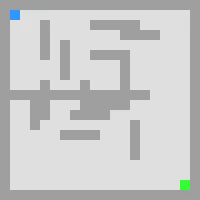

In [38]:
img = env.render('rgb_array')
env = gym.wrappers.Monitor(env, './', force=True, uid=45)
env.reset()
done = False
while not done:
    action = np.argmax(q_table[state])
    state, reward, done, info = env.step(action)
env.close()
f = list(Path('./').glob('*.mp4'))[0]
reader = imageio.get_reader(f)
f = f'./{maze_env.env_id}.gif'
with imageio.get_writer(f, fps=50) as writer:
    [writer.append_data(img) for img in reader]
Img(f)

In [39]:
alpha

0.951701213572782

In [40]:
gamma

0.8801520298755979

In [41]:
epsilon

0.5565593259680558